## Definations 

In [1]:
import numpy as np
import re
from glob import glob
import pandas as pd
import pickle
import os
import re
import matplotlib.pyplot as plt

Mammo_utils has a lot of useful functions which will help in reading pgm images and slice them. 

In [2]:
from mammo_utils import remove_white_from_image, slice_normal_image, create_slices, read_pgm, get_roi_edges, get_fuzzy_offset, get_roi_edges, random_flip_image, progress, extract_slice
%matplotlib inline

## DATA VISUALIZATION

I am going to read the info txt file which just contain the information of the images. Lets see how it's look like. 

In [3]:
main_table = pd.read_table('data/Info.txt',delimiter=' ') # import and clean the annotation data
main_table.head(241)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0
5,mdb005,F,CIRC,B,500,168,26.0
6,mdb006,F,NORM,NaN,NaN,NaN,NaN
7,mdb007,G,NORM,NaN,NaN,NaN,NaN
8,mdb008,G,NORM,NaN,NaN,NaN,NaN
9,mdb009,F,NORM,NaN,NaN,NaN,NaN


Looking at the table above, we can clearly see that there are alot of NaN values which are for the healthy samples. Also, For this project we are just concentrated on the samples which have cancer cells so we have to remove these normal samples to reduce the training data furthermore.

### sizes of radii

Lets analyze the spread of cancer cells so that we can determine the region of interest which should be selected for training the model.

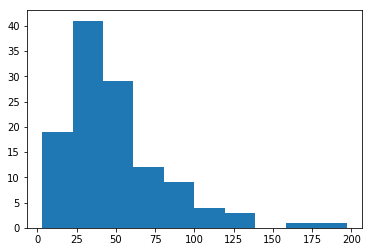

In [4]:
radii = main_table.RADIUS
radii.dropna(inplace=True)
plt.hist(radii)
plt.show()

we can clearly see that the radii goes to 200 so we should have a slice of region of interest greater than this number for the better training and results.

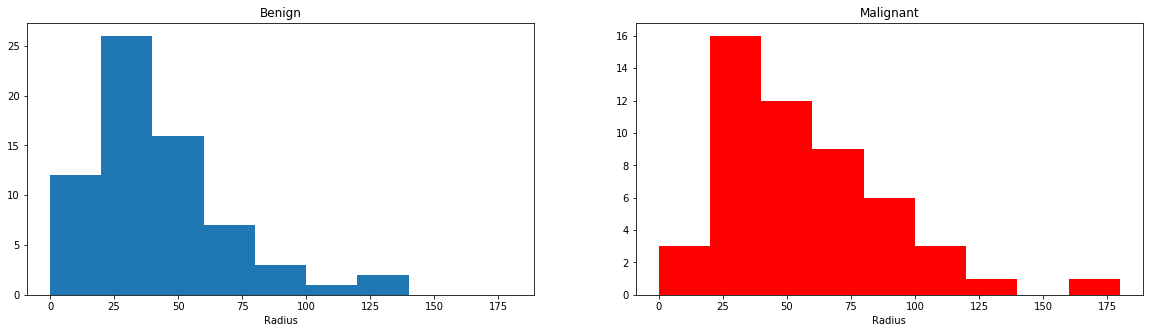

In [7]:
## Look at radii by severity
s_r = main_table.loc[:,['RADIUS','SEVERITY']]
s_r.dropna(axis=0, how='any', inplace=True)
benign = s_r[s_r.SEVERITY == 'B']
malignant = s_r[s_r.SEVERITY == 'M']
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(benign.RADIUS, bins=range(0,200,20))
ax[0].set_xlabel("Radius")
ax[0].set_title("Benign")
ax[1].hist(malignant.RADIUS, color="red",  bins=range(0,200,20))
ax[1].set_title("Malignant")
ax[1].set_xlabel("Radius")
plt.show()

The above histogram shows that there is more radii increment in Malignant than Benign. 

### Drawing images with location of center of abnormality

In [8]:
from matplotlib.patches import Circle

def draw(index):

    if index % 2 == 0: # account for horizontal flip of some images
        plt.imshow(np.fliplr((read_pgm(sorted(glob('all-mias/*.pgm'))[index]))))
        x_location = 1024 - int(main_table.X[index])
        
    else:
        plt.imshow(read_pgm(sorted(glob('all-mias/*.pgm'))[index]))
        x_location = int(main_table.X[index])
        
    plt.plot([x_location],[1024-int(main_table.Y[index])], 'ro')   
    plt.show()

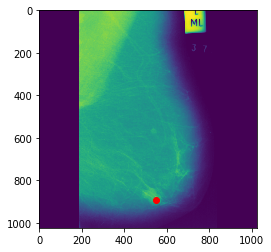

In [9]:
draw(4)

### Remove the rows with NaN

In [10]:
main_table = main_table.dropna(subset=['SEVERITY','X','Y','RADIUS'])

In [11]:
main_table.shape

(119, 7)

### Add Path Column

In [12]:
main_table['path'] = main_table['REFNUM'].map(lambda x: '%s.pgm' % x)

In [13]:
main_table.head(20)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,path
0,mdb001,G,CIRC,B,535,425,197.0,mdb001.pgm
1,mdb002,G,CIRC,B,522,280,69.0,mdb002.pgm
4,mdb005,F,CIRC,B,477,133,30.0,mdb005.pgm
5,mdb005,F,CIRC,B,500,168,26.0,mdb005.pgm
10,mdb010,F,CIRC,B,525,425,33.0,mdb010.pgm
12,mdb012,F,CIRC,B,471,458,40.0,mdb012.pgm
13,mdb013,G,MISC,B,667,365,31.0,mdb013.pgm
15,mdb015,G,CIRC,B,595,864,68.0,mdb015.pgm
17,mdb017,G,CIRC,B,547,573,48.0,mdb017.pgm
19,mdb019,G,CIRC,B,653,477,49.0,mdb019.pgm


# SECTION TWO FOR THE DATA SLICING

In this section, We will separate the region of interest from the whole image and then save these in a file to be used for the training. It will reduce the computations for training alot, as the size of images will reduce greatly. 

### Creating the Image classes 

As we have two categories within malignant and the benign so it's a good idea to create the class column to define both so that we can better catagorize the images.
- benign = 'calcification' or 'mass'
- malignant = 'calcification' or 'mass'

In [14]:
def class_generator(df, idx):
     # get the name of the image from the data
    severity = df.loc[idx]['SEVERITY']
    
    if severity == "M":
        label_img = "MALIGNANT_"
            
    else:
        label_img = "BENIGN_"
    
    return label_img

### Creating Slices Of Region Of Interest

### Create_slices 

This function will create the slices of sizes 299 x 299.
it will create two images of zoom in Region of interest and zoom out Region of interest from same image. That means that it will return images double the amount which was being fed.

In [15]:
def create_slices(df, pgm_dir="all-mias/", scale_by=2.2, slice_size=299, 
                       var_upper_threshold=2000, var_lower_threshold=20, mean_threshold=38, 
                       debug=None):
    # loop through rows in the data frame
    slices = [] # for saving the slices 
    names = [] # for saving the names 
    labels = [] # for saving the labels 
    full_slice = slice_size 
       
    for index, row in df.iterrows(): # Run for the rows in the data 
        
        # get the base file name from the mask name
        image_name = row['path']
        
        if debug is None:
            progress(counter,  len(df), image_name)
            
        # try to open the image, if it doesn't exist continue
        try:
            full_image_arr = read_pgm('all-mias/' +  image_name)
        except:
            print(image_name, "file not found!")
            continue             

        # get the shape of the image
        image_h, image_w = full_image_arr.shape
            
        # get the class of the image
        image_class = class_generator(df, index)
        if debug is True:
            print(image_name, image_class, "abnormal")           
            
            # get the size and shape of the ROI, NOT offset by the number of columns trimmed off
            center_col = int(row['X'])# * scale_by)
            center_row = image_h - int(row['Y'])# * scale_by)

            # the ROI is square so we don't need to get the sizes individually
            roi_size = mask_height = mask_width = mask_size = row['RADIUS'] * scale_by

            #####################################################################################
            ## extract the ROI with context size equal to double ROI size and random augmentation
            if debug:
                print("Adding ROI at size", image_name)

            img_slice = extract_slice(full_image_arr, center_col, center_row, roi_size, padding=1.2, context_scale=2, return_slice_size=299, distort=False)

            if img_slice.shape == (299,299, 1):
                slices.append(img_slice)
                names.append(image_name)
                labels.append(image_class)

            ####################################################################################
            ## Extract the ROI with a smaller margins
            img_slice = extract_slice(full_image_arr, center_col, center_row, roi_size, padding=1.3, context_scale=1.5, return_slice_size=299, distort=False)

            if img_slice.shape == (299,299, 1):
                slices.append(img_slice)
                names.append(image_name)
                labels.append(image_class)

                # if the slice is the right shape add it to the list
                print(img_slice.shape)
                

    return np.array(slices), np.array(labels), names

Getting and cleaning data again

In [16]:
# import and clean the annotation data, this time leave the duplicates
main_table = pd.read_table('data/Info.txt', delimiter=' ')
main_table['path'] = main_table['REFNUM'].map(lambda x: '%s.pgm' % x)
main_table = main_table.dropna(subset=['SEVERITY','X','Y','RADIUS'])

In [18]:
slices, labels, filenames = create_slices(main_table, debug=True)

mdb001.pgm BENIGN_ abnormal
Adding ROI at size mdb001.pgm
(299, 299, 1)
mdb002.pgm BENIGN_ abnormal
Adding ROI at size mdb002.pgm
(299, 299, 1)
mdb005.pgm BENIGN_ abnormal
Adding ROI at size mdb005.pgm
(299, 299, 1)
mdb005.pgm BENIGN_ abnormal
Adding ROI at size mdb005.pgm
(299, 299, 1)
mdb010.pgm BENIGN_ abnormal
Adding ROI at size mdb010.pgm
(299, 299, 1)
mdb012.pgm BENIGN_ abnormal
Adding ROI at size mdb012.pgm
(299, 299, 1)
mdb013.pgm BENIGN_ abnormal
Adding ROI at size mdb013.pgm
(299, 299, 1)
mdb015.pgm BENIGN_ abnormal
Adding ROI at size mdb015.pgm
(299, 299, 1)
mdb017.pgm BENIGN_ abnormal
Adding ROI at size mdb017.pgm
(299, 299, 1)
mdb019.pgm BENIGN_ abnormal
Adding ROI at size mdb019.pgm
(299, 299, 1)
mdb021.pgm BENIGN_ abnormal
Adding ROI at size mdb021.pgm
(299, 299, 1)
mdb023.pgm MALIGNANT_ abnormal
Adding ROI at size mdb023.pgm
(299, 299, 1)
mdb025.pgm BENIGN_ abnormal
Adding ROI at size mdb025.pgm
(299, 299, 1)
mdb028.pgm MALIGNANT_ abnormal
Adding ROI at size mdb028.pgm


mdb270.pgm MALIGNANT_ abnormal
Adding ROI at size mdb270.pgm
(299, 299, 1)
mdb271.pgm MALIGNANT_ abnormal
Adding ROI at size mdb271.pgm
(299, 299, 1)
mdb274.pgm MALIGNANT_ abnormal
Adding ROI at size mdb274.pgm
(299, 299, 1)
mdb290.pgm BENIGN_ abnormal
Adding ROI at size mdb290.pgm
(299, 299, 1)
mdb312.pgm BENIGN_ abnormal
Adding ROI at size mdb312.pgm
(299, 299, 1)
mdb314.pgm BENIGN_ abnormal
Adding ROI at size mdb314.pgm
(299, 299, 1)
mdb315.pgm BENIGN_ abnormal
Adding ROI at size mdb315.pgm
(299, 299, 1)


In [19]:
print("Slices:", slices.shape)
print("Labels:", labels.shape)
print("Filenames:", len(filenames))

Slices: (238, 299, 299, 1)
Labels: (238,)
Filenames: 238


# SLICES VISUALIZATION

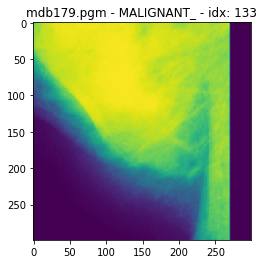

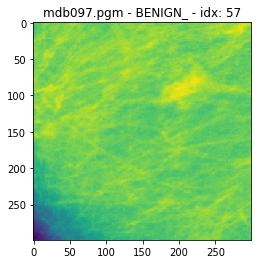

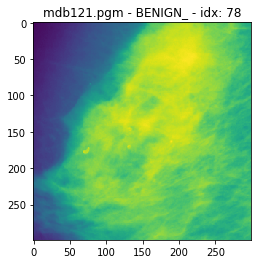

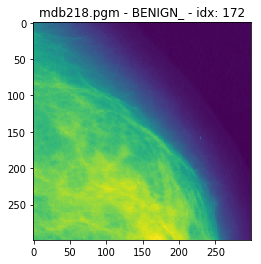

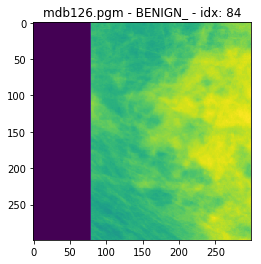

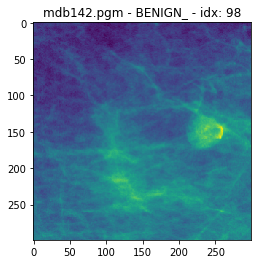

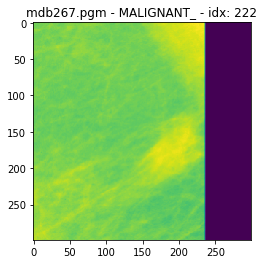

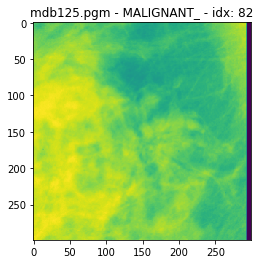

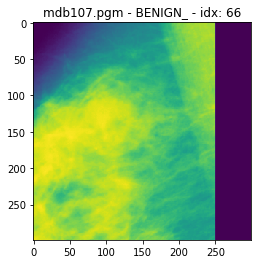

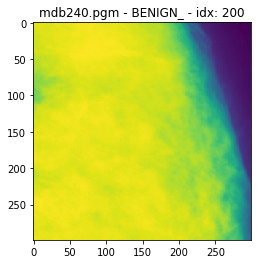

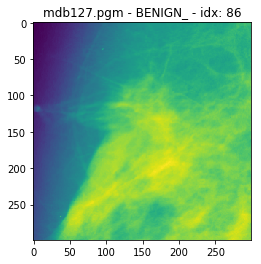

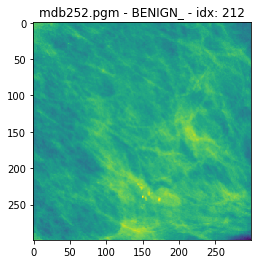

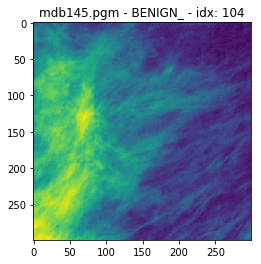

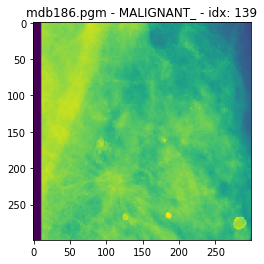

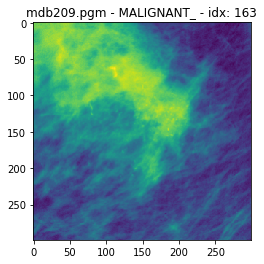

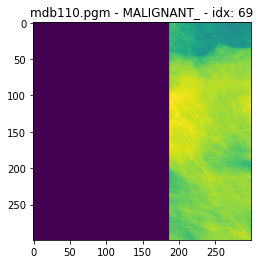

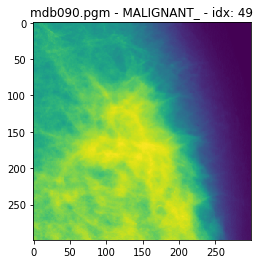

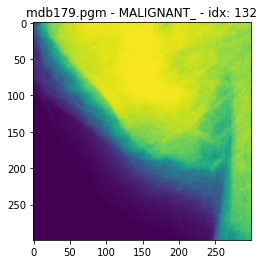

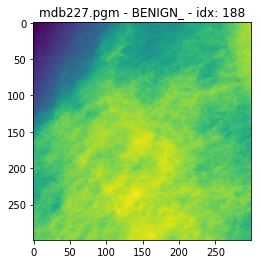

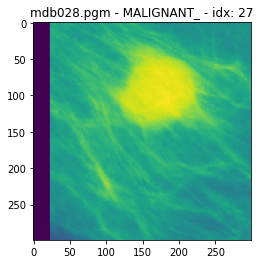

In [20]:
# look at some random images
import random
N = 20
idxs = random.sample(range(len(slices)), k=N)

for idx in idxs:
    plt.imshow(slices[idx].reshape(299,299))
    plt.title(filenames[idx] + " - " + labels[idx] + " - idx: " + str(idx))
    plt.show()



### Save the slices along with their names and labels 

In [21]:
pd.value_counts(labels, normalize=True)

BENIGN_       0.571429
MALIGNANT_    0.428571
dtype: float64

In [22]:
# encode the labels
from sklearn import preprocessing

Converting the classes in the form of numbers 

In [23]:
# create the encoder
le = preprocessing.LabelEncoder()
le.fit(labels)


LabelEncoder()

In [24]:
labels_enc = le.transform(labels) + 1

In [25]:
labels_enc

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
mias_classes = le.classes_

In [27]:
mias_classes

array(['BENIGN_', 'MALIGNANT_'], dtype='<U10')

In [28]:
## save the data
np.save(os.path.join("data", "all_mias_slices.npy"), slices)
np.save(os.path.join("data", "all_mias_labels.npy"), labels_enc)
np.save(os.path.join("data", "all_mias_filenames.npy"), filenames)

# TIME FOR DIVIDING DATA

Now as we are done with creating the slices from the images, it's time to convert the data into train adn test and save it so that we can use it in the training. 

In [29]:
all_normal_images = np.load(os.path.join("data", "all_mias_slices.npy"))

In [30]:
all_normal_labels = np.load(os.path.join("data", "all_mias_labels.npy"))

In [31]:
normal_filenames = np.load(os.path.join("data", "all_mias_filenames.npy"))

In [32]:
from sklearn.model_selection import train_test_split

# now shuffle and split the images 
split_train_normal_images, split_test_normal_images, split_train_normal_labels, split_test_normal_labels, split_train_normal_filenames, split_test_normal_filenames  = train_test_split(all_normal_images, 
all_normal_labels, normal_filenames, test_size=0.1)

In [33]:
print(split_train_normal_images.shape, split_test_normal_images.shape, split_train_normal_labels.shape, split_test_normal_labels.shape, split_train_normal_filenames.shape, split_test_normal_filenames.shape)

(214, 299, 299, 1) (24, 299, 299, 1) (214,) (24,) (214,) (24,)


In [34]:
split_test_normal_labels

array([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2,
       2, 2])

In [35]:
np.save(os.path.join("data", "all_mias_slices_train.npy"), split_train_normal_images)
np.save(os.path.join("data", "all_mias_labels_train.npy"), split_train_normal_labels)
np.save(os.path.join("data", "all_mias_filenames_train.npy"), split_train_normal_filenames)

np.save(os.path.join("data", "all_mias_slices_test.npy"), split_test_normal_images)
np.save(os.path.join("data", "all_mias_labels_test.npy"), split_test_normal_labels)
np.save(os.path.join("data", "all_mias_filenames_test.npy"), split_test_normal_filenames)

In [36]:
image = np.load(os.path.join("data", "all_mias_slices_train.npy"))

In [37]:
image.shape

(214, 299, 299, 1)